In [1]:
!pip install unidecode 

In [2]:
!pip install pysal 

In [3]:
!pip install mapclassify

In [4]:
!pip install numpy 

In [5]:
# data table
import pandas as pd
import os

datadis=pd.read_csv(os.path.join('data','dataPeru_indicadores_1.csv'),dtype={'Ubigeo': object})
datadis.head() 

,Ubigeo,Departamento,Provincia,Distrito,Poblacion,Superficie,IDH2019,Educ_sec_comp2019_pct,NBI2017_pct,Viv_sin_serv_hig2017_pct
0,10202,Amazonas,Bagua,ARAMANGO,10940,809.07,0.36,37.545885,62.9,9.1
1,10201,Amazonas,Bagua,BAGUA,26091,150.99,0.58,70.795501,25.4,0.7
2,10203,Amazonas,Bagua,COPALLIN,6319,99.05,0.47,52.571361,45.4,2.1
3,10204,Amazonas,Bagua,EL PARCO,1492,18.48,0.49,70.215409,59.9,1.5
4,10205,Amazonas,Bagua,IMAZA,24323,4430.84,0.30,31.295719,88.4,11.7


In [6]:
# map

os.environ['USE_PYGEOS'] = '0'

import geopandas as gpd

datadismap=gpd.read_file(os.path.join('maps','DistritosMap'))

datadismap.head()

,DEPARTAMEN,PROVINCIA,DISTRITO,INSTITUCIO,geometry
0,TACNA,TACNA,CORONEL GREGORIO ALBARRACIN LANCHIPA,IGN,"POLYGON ((-70.17413 -18.12896, -70.17461 -18.1..."
1,TACNA,TACNA,POCOLLAY,IGN,"POLYGON ((-69.93475 -17.92557, -69.90467 -17.9..."
2,TACNA,TACNA,CALANA,IGN,"POLYGON ((-70.11604 -17.91106, -70.11457 -17.9..."
3,TACNA,TACNA,TACNA,IGN,"POLYGON ((-70.31490 -17.94498, -70.30682 -17.9..."
4,TACNA,TACNA,SAMA,IGN,"POLYGON ((-70.42497 -17.88934, -70.48022 -17.9..."


In [7]:
capitalizeColumns=lambda x: x.str.upper().str.strip()
datadis[['Provincia','Distrito']]=datadis[['Provincia','Distrito']].apply(capitalizeColumns)
datadismap[['PROVINCIA','DISTRITO']]=datadismap[['PROVINCIA','DISTRITO']].apply(capitalizeColumns)

In [8]:
import unidecode

byePunctuation=lambda x: unidecode.unidecode(x)
datadis[['Provincia','Distrito']]=datadis[['Provincia','Distrito']].applymap(byePunctuation)
datadismap[['PROVINCIA','DISTRITO']]=datadismap[['PROVINCIA','DISTRITO']].applymap(byePunctuation)

In [9]:
len(datadis.Distrito),len(datadismap.DISTRITO)

(1874, 1874)

In [10]:
datadis.Distrito.duplicated().sum(),datadismap.DISTRITO.duplicated().sum()

(154, 152)

In [11]:
# concatenar 
datadis['provDist']=["+".join(pd) for pd in zip (datadis.Provincia,datadis.Distrito)]
datadismap['provDist']=["+".join(pd) for pd in zip (datadismap.PROVINCIA,datadismap.DISTRITO)]

In [12]:
# the new column looks like this:
datadis['provDist'].head()

0    BAGUA+ARAMANGO
1       BAGUA+BAGUA
2    BAGUA+COPALLIN
3    BAGUA+EL PARCO
4       BAGUA+IMAZA
Name: provDist, dtype: object

In [13]:
# replacing dashes and multiple spaces by a simple space
datadis.provDist=datadis.provDist.str.replace("\-|\_|\s+"," ",regex=True)
datadismap.provDist=datadismap.provDist.str.replace("\-|\_|\s+"," ",regex=True)

In [14]:
#merging 

In [15]:
nomatch_df=set(datadis.provDist)- set(datadismap.provDist)
nomatch_gdf=set(datadismap.provDist)-set(datadis.provDist) 

In [16]:
len(nomatch_df), len(nomatch_gdf)

(8, 8)

In [17]:
# pick the closest match from nomatch_gdf for a value in nomatch_df
from thefuzz import process
[(dis,process.extractOne(dis,nomatch_gdf)) for dis in sorted(nomatch_df)]

[('ANGARAES+HUAYLLAY GRANDE', ('ANGARAES+HUALLAY GRANDE', 98)),
 ('AYMARAES+CARAYBAMBA', ('AYMARAES+CARAIBAMBA', 95)),
 ('AYMARAES+HUAYLLO', ('AYMARAES+IHUAYLLO', 97)),
 ('HUARAZ+PAMPAS', ('HUARAZ+PAMPAS GRANDE', 90)),
 ('LEONCIO PRADO+DANIEL ALOMIAS ROBLES',
  ('LEONCIO PRADO+DANIEL ALOMIA ROBLES', 99)),
 ('LIMA+PUEBLO LIBRE', ('LIMA+MAGDALENA VIEJA', 49)),
 ('PIURA+26 DE OCTOBER', ('PIURA+VEINTISEIS DE OCTUBRE', 65)),
 ('SAN MARTIN+PAPAPLAYA', ('SAN MARTIN+PAPA PLAYA', 98))]

In [18]:
# is this OK?
{dis:process.extractOne(dis,nomatch_gdf)[0] for dis in sorted(nomatch_df)}

{'ANGARAES+HUAYLLAY GRANDE': 'ANGARAES+HUALLAY GRANDE',
 'AYMARAES+CARAYBAMBA': 'AYMARAES+CARAIBAMBA',
 'AYMARAES+HUAYLLO': 'AYMARAES+IHUAYLLO',
 'HUARAZ+PAMPAS': 'HUARAZ+PAMPAS GRANDE',
 'LEONCIO PRADO+DANIEL ALOMIAS ROBLES': 'LEONCIO PRADO+DANIEL ALOMIA ROBLES',
 'LIMA+PUEBLO LIBRE': 'LIMA+MAGDALENA VIEJA',
 'PIURA+26 DE OCTOBER': 'PIURA+VEINTISEIS DE OCTUBRE',
 'SAN MARTIN+PAPAPLAYA': 'SAN MARTIN+PAPA PLAYA'}

In [19]:
# then:
changesDis_df={dis:process.extractOne(dis,nomatch_gdf)[0] for dis in sorted(nomatch_df)}

In [20]:
datadis.provDist.replace(changesDis_df,inplace=True)

In [21]:
datadismap=datadismap.merge(datadis, on='provDist')

In [22]:
# check
datadismap.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1874 entries, 0 to 1873
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   DEPARTAMEN                1874 non-null   object  
 1   PROVINCIA                 1874 non-null   object  
 2   DISTRITO                  1874 non-null   object  
 3   INSTITUCIO                1874 non-null   object  
 4   geometry                  1874 non-null   geometry
 5   provDist                  1874 non-null   object  
 6   Ubigeo                    1874 non-null   object  
 7   Departamento              1874 non-null   object  
 8   Provincia                 1874 non-null   object  
 9   Distrito                  1874 non-null   object  
 10  Poblacion                 1874 non-null   int64   
 11  Superficie                1874 non-null   float64 
 12  IDH2019                   1874 non-null   float64 
 13  Educ_sec_comp2019_pct     1874 non-null 

In [23]:
bye=['Departamento', 'Provincia', 'Distrito','INSTITUCIO']
datadismap.drop(columns=bye,inplace=True)

# keeping
datadismap.head()

,DEPARTAMEN,PROVINCIA,DISTRITO,geometry,provDist,Ubigeo,Poblacion,Superficie,IDH2019,Educ_sec_comp2019_pct,NBI2017_pct,Viv_sin_serv_hig2017_pct
0,TACNA,TACNA,CORONEL GREGORIO ALBARRACIN LANCHIPA,"POLYGON ((-70.17413 -18.12896, -70.17461 -18.1...",TACNA+CORONEL GREGORIO ALBARRACIN LANCHIPA,230110,123662,187.74,0.58,71.178389,15.8,0.8
1,TACNA,TACNA,POCOLLAY,"POLYGON ((-69.93475 -17.92557, -69.90467 -17.9...",TACNA+POCOLLAY,230108,22319,265.65,0.65,75.825743,16.1,0.9
2,TACNA,TACNA,CALANA,"POLYGON ((-70.11604 -17.91106, -70.11457 -17.9...",TACNA+CALANA,230103,3338,108.38,0.56,77.829717,15.9,3.3
3,TACNA,TACNA,TACNA,"POLYGON ((-70.31490 -17.94498, -70.30682 -17.9...",TACNA+TACNA,230101,80845,1877.78,0.70,75.491958,7.4,0.6
4,TACNA,TACNA,SAMA,"POLYGON ((-70.42497 -17.88934, -70.48022 -17.9...",TACNA+SAMA,230109,2679,1115.98,0.55,70.500250,52.4,10.8


In [24]:
datadismap.to_file(os.path.join('maps',"dataMapPeru.gpkg"), layer='distritos', driver="GPKG")

CRSError: Invalid input to create CRS: GEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER["World Geodetic System 1984 (Transit)"],MEMBER["World Geodetic System 1984 (G730)"],MEMBER["World Geodetic System 1984 (G873)"],MEMBER["World Geodetic System 1984 (G1150)"],MEMBER["World Geodetic System 1984 (G1674)"],MEMBER["World Geodetic System 1984 (G1762)"],MEMBER["World Geodetic System 1984 (G2139)"],ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[2.0]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],CS[ellipsoidal,2],AXIS["geodetic latitude (Lat)",north,ORDER[1],ANGLEUNIT["degree",0.0174532925199433]],AXIS["geodetic longitude (Lon)",east,ORDER[2],ANGLEUNIT["degree",0.0174532925199433]],USAGE[SCOPE["Horizontal component of 3D system."],AREA["World."],BBOX[-90,-180,90,180]],ID["EPSG",4326]]

In [25]:
#Exploring one variable

In [26]:
# statistics
datadismap.IDH2019.describe()

count    1874.000000
mean        0.409520
std         0.140099
min         0.090000
25%         0.300000
50%         0.390000
75%         0.510000
max         0.850000
Name: IDH2019, dtype: float64

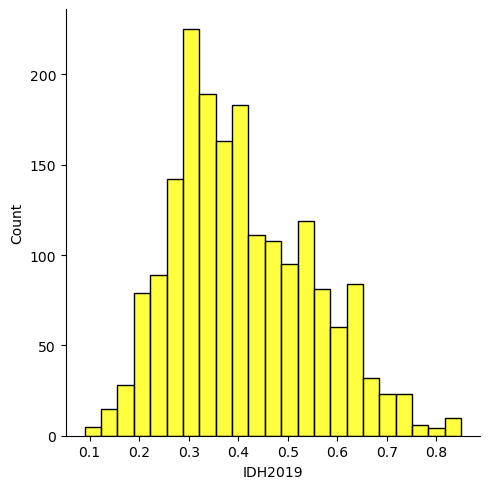

In [27]:
import seaborn as sea

sea.displot(datadismap.IDH2019, color='yellow')

In [28]:
sea.boxplot(datadismap.IDH2019, color='yellow',orient='h')

/Users/valeriaminano/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='IDH2019'>

In [ ]:
import mapclassify 
import numpy as np

np.random.seed(12345) # so we all get the same results!

# let's try 5 intervals
K=5
# same interval width, easy interpretation
ei5 = mapclassify.EqualInterval(datadismap['IDH2019'], k=K)
# same interval width based on standard deviation, easy - but not as the previous one, poor when high skewness
msd = mapclassify.StdMean(datadismap['IDH2019'])
# interval width varies, counts per interval are close, not easy to grasp, repeated values complicate cuts                                
q5=mapclassify.Quantiles(datadismap['IDH2019'],k=K)

# based on similarity, good for multimodal data 
mb5 = mapclassify.MaximumBreaks(datadismap['IDH2019'], k=K)
# based on similarity, good for skewed data
ht = mapclassify.HeadTailBreaks(datadismap['IDH2019']) # no K needed
# based on similarity, optimizer
fj5 = mapclassify.FisherJenks(datadismap['IDH2019'], k=K)
# based on similarity, optimizer
jc5 = mapclassify.JenksCaspall(datadismap['IDH2019'], k=K)
# based on similarity, optimizer
mp5 = mapclassify.MaxP(datadismap['IDH2019'], k=K)